In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/bci-challenge-ner15/

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1yOiYN9j4e9ZXxo8tV9x_d9X1dw-lPwat/bci-challenge-ner15


In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc, make_scorer
from imblearn.over_sampling import SMOTE, ADASYN
import matplotlib.pyplot as plt
from detection import SubjectData
from utils import train_subjects, test_subjects
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

In [2]:
RAND_STATE = 42

In [3]:
labels = pd.read_csv('./data/TrainLabels.csv')
y = labels['Prediction'].to_numpy()
print(y.shape)

(5440,)


In [4]:
X = []
for subject in train_subjects:
  sd = SubjectData(subject, train=True)
  X.append(np.hstack((sd.is_short.reshape(-1, 1), sd.get_green_similarity(), sd.get_feedback_similarity())))
X = np.vstack(X)
print(X.shape)

(5440, 26)


In [5]:
test_set = []
for i in range(len(test_subjects)):
    sd = SubjectData(test_subjects[i], train=False)
    test_set.append(np.hstack((sd.is_short.reshape(-1, 1), sd.get_green_similarity(), sd.get_feedback_similarity())))

test_set = np.vstack(test_set)
print(f'test_set: {test_set.shape}')

test_set: (3400, 26)


In [6]:
def get_session_and_trial(verbose=False):
    features = []
    for i in range(1, 5):
        for j in range(1, 61):
            features.append([i, j])
    for j in range(1, 101):
        features.append([5, j])
    features = np.array(features)
    if verbose: print(f'session_and_trial: {features.shape}')
    return features

def transform_data(X, verbose=False):
  extra_features = get_session_and_trial(verbose=verbose)
  extra_cols = []
  for i in range(X.shape[0] // extra_features.shape[0]):
    extra_cols.append(extra_features)
  extra_cols = np.array(extra_cols)
  extra_cols = extra_cols.reshape(extra_cols.shape[0] * extra_cols.shape[1], extra_cols.shape[2])
  if verbose: print(f'extra_cols: {extra_cols.shape}')
  final_X = np.hstack((extra_cols, X))
  return final_X

In [7]:
test_X = transform_data(test_set, verbose=True)

session_and_trial: (340, 2)
extra_cols: (3400, 2)


In [8]:
final_X = transform_data(X, verbose=True)
print(final_X.shape)

session_and_trial: (340, 2)
extra_cols: (5440, 2)
(5440, 28)


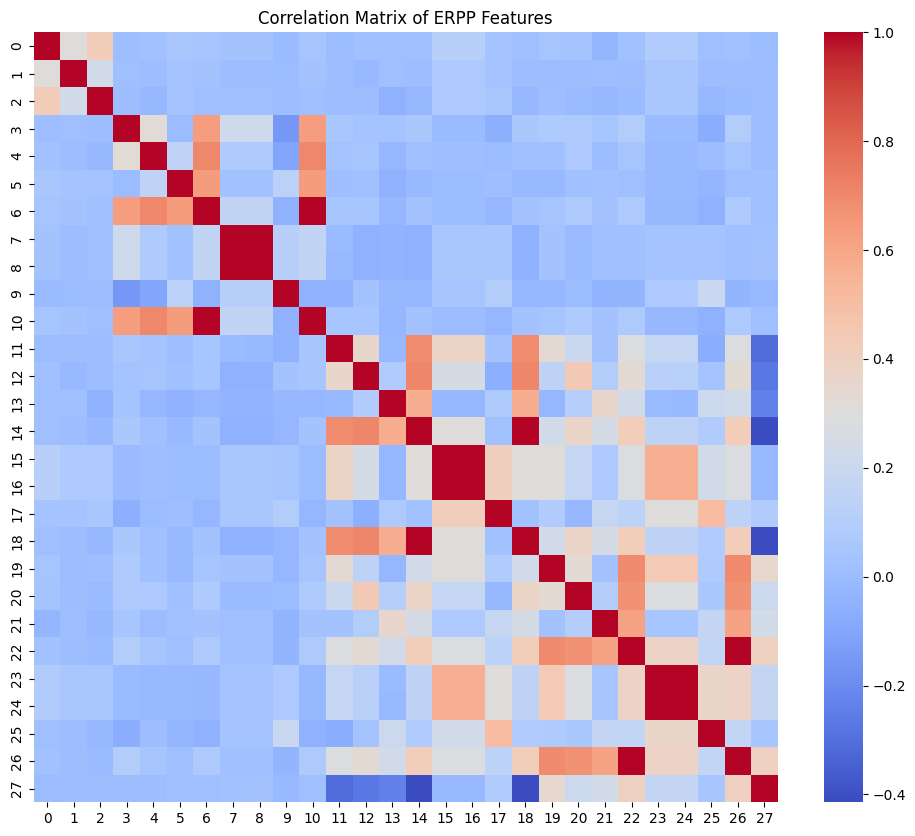

In [11]:
data_corr = pd.DataFrame(final_X)
corr_matrix = data_corr.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of ERPP Features')
plt.show()

In [9]:
def remove_high_correlation_columns_full_matrix(data, threshold=0.8, verbose=False):
    if isinstance(data, np.ndarray):
        data = pd.DataFrame(data)

    corr_matrix = data.corr().abs()
    to_drop = set()

    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):
            if corr_matrix.iloc[i, j] > threshold:
                col_i = corr_matrix.columns[i]
                col_j = corr_matrix.columns[j]

                to_drop.add(col_j)
                if verbose:
                    print(f"Συσχέτιση {col_i} με {col_j}: {corr_matrix.iloc[i, j]:.2f} -> Αφαίρεση {col_j}")


    reduced_data = data.drop(columns=to_drop)
    return reduced_data

reduced_df = remove_high_correlation_columns_full_matrix(final_X, threshold=0.8, verbose=True)
test_X = remove_high_correlation_columns_full_matrix(test_X, threshold=0.8, verbose=True)

Συσχέτιση 6 με 10: 1.00 -> Αφαίρεση 10
Συσχέτιση 7 με 8: 1.00 -> Αφαίρεση 8
Συσχέτιση 14 με 18: 1.00 -> Αφαίρεση 18
Συσχέτιση 15 με 16: 1.00 -> Αφαίρεση 16
Συσχέτιση 22 με 26: 1.00 -> Αφαίρεση 26
Συσχέτιση 23 με 24: 1.00 -> Αφαίρεση 24
Συσχέτιση 6 με 10: 1.00 -> Αφαίρεση 10
Συσχέτιση 7 με 8: 1.00 -> Αφαίρεση 8
Συσχέτιση 14 με 18: 1.00 -> Αφαίρεση 18
Συσχέτιση 15 με 16: 1.00 -> Αφαίρεση 16
Συσχέτιση 22 με 26: 1.00 -> Αφαίρεση 26
Συσχέτιση 23 με 24: 1.00 -> Αφαίρεση 24


In [10]:
print(reduced_df.shape)

(5440, 22)


In [11]:
X_train, X_val, y_train, y_val = train_test_split(reduced_df, y, test_size=0.3, random_state=RAND_STATE)
print(f'X_train: {X_train.shape}\nX_val: {X_val.shape}')

X_train: (3808, 22)
X_val: (1632, 22)


In [12]:
smote = SMOTE(random_state=RAND_STATE)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print(f'X_train_smote: {X_train_smote.shape}')

adasyn = ADASYN(random_state=RAND_STATE)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)
print(f'X_train_adasyn: {X_train_adasyn.shape}')

X_train_smote: (5356, 22)
X_train_adasyn: (5422, 22)


In [16]:
def auc_scorer(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    return auc(fpr, tpr)
auc_score = make_scorer(auc_scorer, needs_proba=True)

In [14]:
def grid_search_rf(X_train, y_train, X_val, y_val, grid, cv=5):
  gscv = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
  )
  model = gscv.fit(X_train, y_train)
  print('Grid Train:')
  print(f'| Best parameters: {model.best_params_}')
  print(f'| Best score: {model.best_score_}')

  y_proba = model.predict_proba(X_val)[:, 1]
  fpr, tpr, thresholds = roc_curve(y_val, y_proba)
  final_auc = auc(fpr, tpr)
  print("| Final AUC score on val set:", final_auc)
  print('-' * 30)


In [15]:
rf_param_grid = {
    'n_estimators': [100, 400, 550],
    'max_depth': [None, 10, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [1, 2, 4],
    #'max_features': ['sqrt', 'log2', None],
}
print("-----[ SMOTE ]-----")
grid_search_rf(X_train_smote, y_train_smote, X_val, y_val, rf_param_grid)

print("-----[ ADASYN ]-----")
grid_search_rf(X_train_adasyn, y_train_adasyn, X_val, y_val, rf_param_grid)

-----[ SMOTE ]-----
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Grid Train:
| Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 550}
| Best score: 0.8673520286088736
| Final AUC score on val set: 0.6625204036207153
------------------------------
-----[ ADASYN ]-----
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Grid Train:
| Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 550}
| Best score: 0.8744053755910886
| Final AUC score on val set: 0.6612943315031903
------------------------------


In [16]:
optimized_param_grid = {
    'n_estimators': [500, 550, 600],
    'max_depth': [None, 5],
    'min_samples_split': [4, 5, 6],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2', None]
}

print("-----[ SMOTE ]-----")
grid_search_rf(X_train_smote, y_train_smote, X_val, y_val, optimized_param_grid)

#print("-----[ ADASYN ]-----")
#grid_search_rf(X_train_adasyn, y_train_adasyn, X_val, y_val, optimized_param_grid)

-----[ SMOTE ]-----
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Grid Train:
| Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 550}
| Best score: 0.8700444362439441
| Final AUC score on val set: 0.6599625315328683
------------------------------


In [18]:
best_model = RandomForestClassifier(
    n_estimators = 550,
    max_depth = None,
    min_samples_leaf = 1,
    min_samples_split = 5,
)
best_model.fit(X_train_smote, y_train_smote)
pred = best_model.predict_proba(test_X)[:, 1]
print(f'pred: {pred.shape}')
print(pred)

pred: (3400,)
[0.72343506 0.61593723 0.56499267 ... 0.44611472 0.56516234 0.57104978]


In [19]:
# Construct IdFeedback column
ids = []
for i in range(len(test_subjects)):
    name = f'S{test_subjects[i]}'
    for session in range(1, 5):
        for fid in range(1, 61):
            ids.append(f'{name}_Sess{session:02}_FB{fid:03}')
    for fid in range(1, 101):
        ids.append(f'{name}_Sess05_FB{fid:03}')
ids = np.array(ids)
print(f'ids: {ids.shape}')
print(ids)

ids: (3400,)
['S01_Sess01_FB001' 'S01_Sess01_FB002' 'S01_Sess01_FB003' ...
 'S25_Sess05_FB098' 'S25_Sess05_FB099' 'S25_Sess05_FB100']


In [21]:
result = pd.DataFrame({
    'IdFeedback': ids,
    'Prediction': pred
})
result.to_csv('./rf_smote_templates1.csv', sep=',', index=False)